# Scaling for the ACCESS-OM3 global 100km Configuration

## Overview
This notebook describes the setup and steps for conducting scaling analyses of the ACCESS-OM3 global 100km configuration. TThe goal is to evaluate model performance across different processor layouts for all NUOPC run phases. The workflow involves three main tools,
- [experiment-generator](https://github.com/ACCESS-NRI/access-experiment-generator) - generates branch configurations for scaling experiments,
- [experiment-runner](https://github.com/ACCESS-NRI/access-experiment-runner) - executes the generated experiments,
- [esmf-trace](https://github.com/ACCESS-NRI/esmf-trace) - postprocesses runtime profiling output to analyse scaling and efficiency.


## Model configuration
### Repo
The base configuration used in this analysis is:
> git@github.com:ACCESS-NRI/access-om3-configs.git @`dev-MC_100km_jra_ryf` @`e8f7559`

## Experiment generation 

### [experiment-generator](https://github.com/ACCESS-NRI/access-experiment-generator)

Below is the yaml plan to generate experiment branches using experiment-generator,
```yaml
model_type: access-om3
repository_url: git@github.com:ACCESS-NRI/access-om3-configs.git
start_point: "e8f7559" # Control commit hash for new branches
test_path: "." # All control and perturbation experiment repositories will be created here; can be relative, absolute or ~ (user-defined)
repository_directory: dev-MC-100km-ryf # Local directory name for the central repository (user-defined)
control_branch_name: ctrl
Control_Experiment:

Perturbation_Experiment:
  Parameter_block_global_100km_all1:
    branches: ['dev-MC-100km-ryf_1', 'dev-MC-100km-ryf_2', 'dev-MC-100km-ryf_3', 'dev-MC-100km-ryf_4', 'dev-MC-100km-ryf_5', 'dev-MC-100km-ryf_6', 'dev-MC-100km-ryf_7', 'dev-MC-100km-ryf_8', 'dev-MC-100km-ryf_9', 'dev-MC-100km-ryf_10', 'dev-MC-100km-ryf_11', 'dev-MC-100km-ryf_12', 'dev-MC-100km-ryf_13']

    MOM_input:
      RESTART_CHECKSUMS_REQUIRED: false
      AUTO_MASKTABLE:
        - REMOVE
        - PRESERVE
        - PRESERVE
        - PRESERVE
        - PRESERVE
        - PRESERVE
        - PRESERVE
        - PRESERVE
        - PRESERVE
        - PRESERVE
        - PRESERVE
        - PRESERVE
        - PRESERVE

    ice_in:
      domain_nml:
        max_blocks: -1

    config.yaml:

      env:
        ESMF_RUNTIME_PROFILE: "on"
        ESMF_RUNTIME_TRACE: "on"
        ESMF_RUNTIME_TRACE_PETLIST: ['0 13', '0 26', '0 39', '0 52', '0 65', '0 78', '0 91', '0 104', '0 117', '0 130', '0 143', '0 2', '0 6']
        ESMF_RUNTIME_PROFILE_OUTPUT: "SUMMARY"

      ncpus: [26   , 91     , 156     , 221     , 286     , 351     , 416     , 481     , 546     , 611     , 663     , 208     , 208     ]
      mem: ['500GB', '500GB', '1000GB', '1500GB', '1500GB', '2000GB', '2000GB', '2500GB', '3000GB', '3000GB', '3500GB', '1000GB', '1000GB']
      walltime: ['05:00:00']

      metadata:
        enable: true

      queue: [normalsr]
      platform:
          nodesize: 104
          nodemem: 512
      # repeat: True

    nuopc.runconfig:
      PELAYOUT_attributes:
        atm_ntasks: &ntasks52 [13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143, 2, 6]
        cpl_ntasks: *ntasks52
        ice_ntasks: *ntasks52
        ocn_ntasks: [13, 65, 117, 169, 221, 273, 325, 377, 429, 481, 520, 206, 202]
        ocn_rootpe: *ntasks52
        rof_ntasks: *ntasks52

      CLOCK_attributes:
        restart_n: 10
        restart_option: ndays
        stop_n: 10
        stop_option: ndays
```
This setup produces 13 perturbation branches under `dev-MC-100km-ryf/`, each representing an experiment with increasing processor counts.

Because profiling is performed with [`esmf-trace`](https://github.com/ACCESS-NRI/esmf-trace), each experiment simulates only 10 model days, which is sufficient to capture detailed performance characteristics while keeping costs low.

For this configuration with a coupling timestep of 3600 s (1 hour), there are 240 run-phase steps per run. This duration provides stable performance statistics while avoiding unnecessary computational overhead. This is ideal for high-res experiments such as this 100 km global setup.

### Runtime tracing configuration
#### Profiling with ESMF runtime
ESMF provides built-in profiling and tracing capabilities. When `ESMF_RUNTIME_PROFILE` and `ESMF_RUNTIME_TRACE` are enabled, the framework collects timing information for all major component phases:
- Init1
- RunPhase1
- FinalizePhase1

These timings can be written as binary trace streams and summary text reports (for quick inspection). In this analysis, both formats are enabled.

To limit data volume while preserving accuracy, only the first [PET (persistent execution thread)](https://earthsystemmodeling.org/docs/nightly/develop/ESMF_usrdoc/node8.html) of each component is traced. A PET in ESMF corresponds to a task or MPI rank. For the `MC-100km-ryf` setup, only selected PETs are traced (e.g. PET 0 for the sequential components and PET 13 for the concurrently running ocean component). This approach captures the most computationally active processors while avoiding large unnecessary trace outputs.

Below is the corresponding environment configuration:
```yaml
      env:
        ESMF_RUNTIME_PROFILE: "on"
        ESMF_RUNTIME_TRACE: "on"
        ESMF_RUNTIME_TRACE_PETLIST: ['0 13', '0 26', '0 39', '0 52', '0 65', '0 78', '0 91', '0 104', '0 117', '0 130', '0 143', '0 2', '0 6']
        ESMF_RUNTIME_PROFILE_OUTPUT: "SUMMARY"
```

- In `dev-MC-100km-ryf_1`, the ICE, ATM, ROF, and MED components share the first 52 cores and run sequentially.
- The OCN component runs concurrently on 13 cores.
- PET 0 (for sequential components) and PET 13 (first ocean PET) are traced.

### Running Experiments with [experiment-runner](https://github.com/ACCESS-NRI/access-experiment-runner)
The experiments are executed using the ACCESS Experiment-Runner. Below is the yaml plan,
```yaml
test_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3 # All control and perturbation experiment repositories.
repository_directory: dev-MC-100km-ryf # Local directory name for the central repository, where the running_branches are forked from.
keep_uuid: True
# ================= 1 =================
running_branches: ['dev-MC-100km-ryf_1', 'dev-MC-100km-ryf_2', 'dev-MC-100km-ryf_3', 'dev-MC-100km-ryf_4', 'dev-MC-100km-ryf_5', 'dev-MC-100km-ryf_6', 'dev-MC-100km-ryf_7', 'dev-MC-100km-ryf_8', 'dev-MC-100km-ryf_9', 'dev-MC-100km-ryf_10', 'dev-MC-100km-ryf_11', 'dev-MC-100km-ryf_12', 'dev-MC-100km-ryf_13']

nruns: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

startfrom_restart: ['cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold']
```
Each experiment runs once and starts from a cold start, ensuring reproducibility and independent scaling measurements.

## Postprocessing trace timeseries

### ESMF traceout
After each run we are having a `traceout` directory for each configuration, such as under `dev-MC-100km-ryf_1/dev-MC-100km-ryf/archive/output/traceout`,
```bash
esmf_stream_0000  esmf_stream_0013  metadata
```
where,
 - `esmf_stream_xxxx` – binary trace streams, one per PET traced.
 - `metadata` – describes the trace context (e.g. PET IDs, timing units, region names) so the streams can be interpreted together via the Common Trace Format (CTF).

### [`esmf-trace`](https://github.com/ACCESS-NRI/esmf-trace)
esmf-trace parses and processes the `ESMF` trace files to produce timeseries and summary statistics for each component. It provides two main commands:

1. Generate json timeseries

`esmf-trace run-from-yaml --config run-config.yaml`

2. Generate summarised statistics

`esmf-trace post-summary-from-yaml --config run-config.yaml`

The resulting summaries are analogous to FMS timing output but are per-timestep rather than integrated over the entire run. One example is,

| name | hits | tmin | tmax | tavg | tmedian | tstd | pemin | pemax |
|------|------|------|------|------|----------|------|-------|-------|
| postprocessing_dev-MC-100km-ryf_1/output000/[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7 | 2 | 0.773399 | 95.048981 | 47.911190 | 47.911190 | 66.662903 | 0 | 0 |
| postprocessing_dev-MC-100km-ryf_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1 | 288 | 0.018944 | 0.195784 | 0.038370 | 0.028390 | 0.028717 | 0 | 0 |

#### Flame graph
`esmf-trace` can also generate flame graphs, which visualize time spent in nested calls. The wider a block appears, the more time that call consumed hence it is a valuable guide for identifying computational hotspots and optimisation targets.

---

‼️ Note:
The generation of json timeseries and postprocessing summaries is currently **only** supported via command-line execution, **not directly** within Jupyter notebooks.

Once the outputs are created, they can be saved into pandas as `.parquet` files for further statistical and scaling analysis. The following notebook starts from this `.parquet` file.

# Running this notebook on Gadi
These steps set up esmf-trace and hook your virtual environment into Gadi Jupyter session.

### Clone the repo
```bash
git clone https://github.com/ACCESS-NRI/esmf-trace
cd esmf-trace
```

### Create & activate a virtual environment
```
python -m venv .venv
. .venv/bin/activate
```

### Load required modules (for babeltrace2)
`babeltrace2` has been installed under `access-nri/model-tools`, hence you can load it directly from,
```
module use /g/data/vk83/modules && module load model-tools/babeltrace2/2.1.2
source .venv/bin/activate
```

### Install esmf-trace and check installation status
```
pip install -r requirements.txt
pip install -e .
esmf-trace --help
```

Or for convenience you can simply run the setup script,
```
./setup.sh
module use /g/data/vk83/modules && module load model-tools/babeltrace2/2.1.2
source .venv/bin/activate
esmf-trace --help
```

### Using the venv in ARE
When launching a notebook on Gadi, click `Show advanced settings`,

Set `Module directories` to `/g/data/vk83/modules`

Set `Python or Conda virtual environment base` to your venv path such as `path/to/esmf-trace/.venv`

In [1]:
from access.esmf_trace.tmp_yaml_parser import read_yaml, write_yaml
from access.esmf_trace.postprocess import _norm_model_component
import pandas as pd
from pathlib import Path

import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

## Generate `run-config.yaml` for `run-from-yaml`
Before extracting the timing timeseries, we first need to create a configuration file named for example, `run-config.yaml`. This file tells `esmf-trace` what to read, which components or phases to extract, and where to output the processed data.

The helper function below automatically generates a properly formatted `run-config.yaml`, which will later be used to produce a json timeseries file by the following through the command line,

```
esmf-trace run-from-yaml --config run-config.yaml
```

In [2]:
DEFAULTS = {
    "stream_prefix": "esmf_stream",
    # "max_workers": 48, # can be auto-determined based on the applied cores
    "xaxis_datetime": False,
    "separate_plots": False,
    "cmap": "tab10",
    "renderer": "browser",
    "show_html": False,
}

def gen_run_config(
    *,
    post_base_path: str,
    model_component: str,
    base_prefix: str,
    count: int,
    list_pets: list[str],
    list_exact_path: list[str],
):
    runs = []
    for i in range(1, count + 1):
        name = f"{base_prefix}_{i}"
        r = {
            "base_prefix": name,
            "pets": list_pets[i-1],
        }

        r["exact_path"] = list_exact_path[i-1]

        runs.append(r)

    return {
        "default_settings": {
            "post_base_path": post_base_path,
            "model_component": model_component,
            "max_workers": 12, # default workers dont run on login node. 
            **DEFAULTS
        },
        "runs": runs,
    }

## Generate `postprocessing-config.yaml` for `post-summary-from-yaml`
After creating json timeseries with `run-from-yaml`, we postprocess them into concise and timestep-aware summary tables (similar in spirit to FMS timing output).
This helper function helps generate a `postprocessing-config.yaml` that tells `esmf-trace` which inputs to read, how to group/phases to aggregate, and where to write the summaries.

```
esmf-trace post-summary-from-yaml --config postprocessing-config.yaml
```


In [3]:
DEFAULTS = {
    "stream_prefix": "esmf_stream",
    "timeseries_suffix": "_timeseries.json",
}

def gen_postprocessing_config(
    *,
    post_prefix: str = "postprocessing",
    base_prefix: str,
    model_component: str | list[str],
    post_base_path: str,
    count: int,
    save_json_path: str,
    list_pets: list[str],
    stats_start_index: int,
    stats_end_index: int,
):
    runs = []
    for i in range(1, count + 1):
        name = f"{post_prefix}_{base_prefix}_{i}"
        r = {
            "name": name,
            "pets": list_pets[i-1],
        }
        runs.append(r)

    return {
        "default_settings": {
            "post_base_path": post_base_path,
            "model_component": model_component,
            "save_json_path": save_json_path,
            "stats_start_index": stats_start_index,
            "stats_end_index": stats_end_index,
            **DEFAULTS
        },
        "runs": runs,
    }

## plot for scaling

In [4]:
plt.rcParams.update({
    "font.size": 15,
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

def _extract_component_from_name(base_prefix, name):
    s = str(name)
    if "/output" in s or "/combine/" in s:
        after = s.split("/", 1)[1]
        parts = after.split("/", 1)
        return parts[1] if len(parts) > 1 else None
    return None

def _filter_by_components_index(stats_df, base_prefix, comps):
    if not comps:
        return stats_df
    wanted = {c.strip() for c in comps}
    idx = stats_df.index.to_series()
    keep = idx.map(lambda nm: (_extract_component_from_name(base_prefix, str(nm)) or "").strip() in wanted)
    return stats_df[keep]

def _parse_name_index(base_prefix, name):
    s = str(name)
    if "/output" in s:
        after = s.split("/", 1)[1]
        output_name = after.split("/", 1)[0]
    elif "/combine/" in s:
        output_name = "combine"
    else:
        output_name = None
    m = re.search(rf"{re.escape(base_prefix)}_(\d+)", s)
    if not m:
        head = s.split("/", 1)[0]
        m = re.search(r"_(\d+)(?:$|[_/])", head)
    case_id = int(m.group(1)) if m else None
    return case_id, output_name

def _build_pivot(stats_df, base_prefix, cores, ycol, outputs, aggfunc="mean", case_order: list[str] | None = None):
    df = stats_df.copy()
    parsed = df.index.to_series().map(lambda s: _parse_name_index(base_prefix, str(s)))
    df["__case_id"] = parsed.map(lambda t: t[0])
    df["__output_name"] = parsed.map(lambda t: t[1])
    df = df[df["__output_name"].isin(outputs)].copy()

    df["__case_prefix"] = df.index.to_series().apply(lambda x: str(x).split("/")[0])

    if case_order is not None:
        order_map = {name: i for i, name in enumerate(case_order)}
        df["__order"] = df["__case_prefix"].map(order_map)
        df = df[df["__order"].notna()].copy()
        df["__order"] = df["__order"].astype(int)
    else:
        # old behaviour: numeric by case_id
        order = df["__case_id"].copy()
        df["__order"] = order.astype(int)

    df = df.sort_values(["__order", "__output_name"], kind="mergesort")

    piv = df.pivot_table(index="__order", columns="__output_name",
                         values=ycol, aggfunc=aggfunc)#.sort_index()

    for col in outputs:
        if col not in piv.columns:
            piv[col] = np.nan
    piv = piv.loc[:, list(outputs)]

    piv.index = pd.Index(cores[:len(piv.index)], name="cores")
    x = piv.index.to_numpy(dtype=float)
    return piv, x

def _style_axes_with_top_index(ax, x, logx=False, logy=False,
                               xlabel="Number of CPUs", top_label="Index", rotate=45):
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")

    ax.xaxis.set_major_locator(mticker.FixedLocator(x))
    ax.xaxis.set_major_formatter(mticker.FixedFormatter([str(int(v)) for v in x]))
    ax.xaxis.set_minor_locator(mticker.NullLocator())
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    for lb in ax.get_xticklabels():
        lb.set_rotation(rotate)
    ax.set_xlabel(xlabel)

    ax2 = ax.twiny()
    if logx:
        ax2.set_xscale("log")
    ax2.set_xlim(ax.get_xlim())
    ax2.xaxis.set_major_locator(mticker.FixedLocator(x))
    ax2.xaxis.set_major_formatter(mticker.FixedFormatter([str(i) for i in range(len(x))]))
    ax2.xaxis.set_minor_locator(mticker.NullLocator())
    ax2.xaxis.set_minor_formatter(mticker.NullFormatter())
    for lb in ax2.get_xticklabels():
        lb.set_rotation(rotate)
    ax2.set_xlabel(top_label)
    return ax2

def plot_scaling(stats_df: pd.DataFrame,
                 base_prefix: str,
                 ycol: str = "tmedian",
                 outputs: tuple[str, ...] = ("combine",),
                 output_for_ideal: str = "combine",
                 ideal_ref_index: int = 1,
                 title: str = "Strong scaling",
                 ylabel: str | None = None,
                 figsize: tuple[int, int] = (20, 6),
                 loglog: bool = True,
                 model_component: str | list[str] | None = None,
                 subplot_by_component: bool = False,
                 subplot_nrow: int | None = None,
                 subplot_ncol: int | None = None,
                 ylim=None,
                 new_vars: dict[str, list[str]] | None = None,
                 cores_per_component: dict[str, list[int]] | None = None,
                 case_order: list[str] | None = None,
                 ):
    if not cores_per_component:
        raise ValueError("`cores_per_component` is required and cannot be empty.")

    comps = []
    comp_labels = []

    mc = _norm_model_component(model_component)
    if mc:
        comps.extend(mc)
        comp_labels.extend([c.split("/")[-1] for c in mc])

    if new_vars:
        for new_name, parts in new_vars.items():
            parts_norm = _norm_model_component(parts) or []
            if not parts_norm:
                raise ValueError(f"-- new_var '{new_name}' has no components!")
            comps.append(parts_norm)
            comp_labels.append(new_name)

    if not comps:
        comps = [None]
        comp_labels = ["(all)"]

    # subplot setup
    if subplot_by_component and len(comps) > 1:
        if subplot_nrow is None or subplot_ncol is None:
            subplot_ncol = 2
            subplot_nrow = int(np.ceil(len(comps) / subplot_ncol))
        fig, axes = plt.subplots(subplot_nrow, subplot_ncol, figsize=figsize)
        axes = np.array(axes).flatten()
        for extra_ax in axes[len(comps):]:
            extra_ax.remove()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = np.array([ax])

    pivot_blocks, keys = [], []
    idx_series = stats_df.index.to_series().astype(str)

    label_keys = []
    cores_map = {}
    for comp, short_lbl in zip(comps, comp_labels):
        label_key = short_lbl if comp is not None else "(all)"
        if label_key not in cores_per_component:
            if comp is None:
                raise KeyError("No cores specified for component '(all)' in cores_per_component.")
        else:
            cores_map[label_key] = np.asarray(cores_per_component[label_key], dtype=float)
            label_keys.append(label_key)

    if not subplot_by_component or len(comps) == 1:
        # union for single-panel x-axis
        x_union = np.array(sorted(set(np.concatenate([cores_map[k] for k in label_keys]))), dtype=float)

    for i, (comp, short_lbl) in enumerate(zip(comps, comp_labels)):
        ax = axes[i if i < len(axes) else -1]

        # cores for this component
        label_key = short_lbl if comp is not None else "(all)"
        if label_key not in cores_per_component:
            raise KeyError(f"No cores specified for component '{label_key}' in cores_per_component.")
        cores_use = np.asarray(cores_per_component[label_key], dtype=float)

        if comp is None:
            df_use = stats_df
            aggfunc = "mean"
        elif isinstance(comp, (list, tuple, set)):
            df_use = _filter_by_components_index(stats_df, base_prefix, list(comp))
            aggfunc = "sum"
        else:
            df_use = _filter_by_components_index(stats_df, base_prefix, [short_lbl])
            if df_use.empty:
                df_use = stats_df[idx_series.str.contains(re.escape(short_lbl), regex=True)]
            aggfunc = "mean"

        if df_use.empty:
            print(f"-- No data found for component '{short_lbl}'. Skipping.")
            continue

        if case_order is not None:
            df_use = df_use.copy()
            df_use["__case_prefix"] = df_use.index.to_series().apply(
                lambda x: str(x).split("/")[0]
            )
            df_use["__case_order"] = df_use["__case_prefix"].apply(
                lambda s: case_order.index(s) if s in case_order else len(case_order)
            )
            df_use = df_use.sort_values("__case_order")

            # print(df_use)

        pivot, _ = _build_pivot(df_use, base_prefix, cores_use, ycol, outputs, aggfunc=aggfunc, case_order=case_order)

        if ("combine" in outputs) and ("combine" not in pivot.columns):
            present_output_cols = [c for c in pivot.columns if isinstance(c, str) and c.startswith("output")]
            if present_output_cols:
                pivot["combine"] = pivot[present_output_cols].sum(axis=1, skipna=True)

        # plot outputs
        for out in outputs:
            if out not in pivot.columns:
                continue
            y = pivot[out].to_numpy(dtype=float)
            mask = np.isfinite(cores_use) & np.isfinite(y)
            if loglog:
                mask &= (cores_use > 0) & (y > 0)
            if not mask.any():
                continue

            x_plot, y_plot = cores_use[mask], y[mask]
            label = short_lbl
            line, = ax.plot(x_plot, y_plot, "o-", linewidth=1.2, markersize=3, label=label)

            # ideal line
            if out == output_for_ideal and (0 <= ideal_ref_index < len(x_plot)):
                y0, x0 = y_plot[ideal_ref_index], x_plot[ideal_ref_index]
                ax.plot(x_plot, y0 * (x0 / x_plot), "--", linewidth=1.0,
                        color=line.get_color(),
                        #label=(f"{label} (ideal)" if not subplot_by_component or len(comps) == 1 else "ideal")
                       )

        if loglog:
            ax.set_xscale("log")
            ax.set_yscale("log")

        if subplot_by_component and len(comps) > 1:
            _ = _style_axes_with_top_index(ax, cores_use, logx=loglog, logy=loglog,
                                           xlabel="Number of CPUs", top_label="Index", rotate=45)
            ax.set_title(short_lbl)

        pivot_blocks.append(pivot)
        keys.append(label_key)

        if ylim is not None:
            if isinstance(ylim, tuple):
                ax.set_ylim(*ylim)
            elif isinstance(ylim, dict) and label_key in ylim:
                ax.set_ylim(*ylim[label_key])

        if not (subplot_by_component and len(comps) > 1):
            ax = axes[0]
            if loglog:
                ax.set_xscale("log")
                ax.set_yscale("log")
            ax.set_xticks(x_union)
            ax.set_xticklabels([str(int(v)) for v in x_union], rotation=45)
            ax.set_xlabel("Number of CPUs")

    axes[0].set_ylabel(ylabel or ycol)
    if not (subplot_by_component and len(comps) > 1):
        axes[0].set_title(title)
    else:
        fig.suptitle(title, y=0.98)

    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        if h:
            uniq = dict(zip(l, h))
            ax.legend(uniq.values(), uniq.keys(), ncol=2)
            ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    pivot_summary = pd.concat(pivot_blocks, axis=1, keys=keys)
    pivot_summary.index.name = "cores"

    # reorder only for the pivot table
    all_cores = set()
    for lst in cores_per_component.values():
        all_cores.update(lst)
    ordered_cores = sorted(all_cores)
    
    pivot_summary = pivot_summary.reindex(ordered_cores)
    return pivot_summary

def plot_speedup(stats_df: pd.DataFrame,
                 base_prefix: str,
                 ycol: str = "tmedian",
                 outputs: tuple[str, ...] = ("combine",),
                 output_for_ideal: str = "combine",
                 ideal_ref_index: int = 1,
                 title: str = "Speedup",
                 ylabel: str | None = "Speedup",
                 figsize: tuple[int, int] = (20, 6),
                 loglog: bool = False,
                 model_component: str | list[str] | None = None,
                 subplot_by_component: bool = False,
                 subplot_nrow: int | None = None,
                 subplot_ncol: int | None = None,
                 ylim=None,
                 new_vars: dict[str, list[str]] | None = None,
                 cores_per_component: dict[str, list[int]] | None = None,
                 case_order: list[str] | None = None,
                 ):
    if not cores_per_component:
        raise ValueError("`cores_per_component` is required and cannot be empty.")

    comps, comp_labels = [], []
    mc = _norm_model_component(model_component)
    if mc:
        comps.extend(mc); comp_labels.extend([c.split("/")[-1] for c in mc])
    if new_vars:
        for new_name, parts in new_vars.items():
            parts_norm = _norm_model_component(parts) or []
            if not parts_norm:
                raise ValueError(f"-- new_var '{new_name}' has no components!")
            comps.append(parts_norm); comp_labels.append(new_name)
    if not comps:
        comps, comp_labels = [None], ["(all)"]

    if subplot_by_component and len(comps) > 1:
        if subplot_nrow is None or subplot_ncol is None:
            subplot_ncol = 2
            subplot_nrow = int(np.ceil(len(comps) / subplot_ncol))
        fig, axes = plt.subplots(subplot_nrow, subplot_ncol, figsize=figsize)
        axes = np.array(axes).flatten()
        for extra_ax in axes[len(comps):]:
            extra_ax.remove()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = np.array([ax])

    metric_blocks, keys = [], []
    idx_series = stats_df.index.to_series().astype(str)

    label_keys, cores_map = [], {}
    for comp, short_lbl in zip(comps, comp_labels):
        label_key = short_lbl if comp is not None else "(all)"
        if label_key in cores_per_component:
            cores_map[label_key] = np.asarray(cores_per_component[label_key], dtype=float)
            label_keys.append(label_key)
    if not subplot_by_component or len(comps) == 1:
        x_union = np.array(sorted(set(np.concatenate([cores_map[k] for k in label_keys]))), dtype=float)

    for i, (comp, short_lbl) in enumerate(zip(comps, comp_labels)):
        ax = axes[i if i < len(axes) else -1]
        label_key = short_lbl if comp is not None else "(all)"
        if label_key not in cores_per_component:
            raise KeyError(f"No cores specified for component '{label_key}'.")
        cores_use = np.asarray(cores_per_component[label_key], dtype=float)

        # df selection
        if comp is None:
            df_use = stats_df; aggfunc = "mean"
        elif isinstance(comp, (list, tuple, set)):
            df_use = _filter_by_components_index(stats_df, base_prefix, list(comp)); aggfunc = "sum"
        else:
            df_use = _filter_by_components_index(stats_df, base_prefix, [short_lbl])
            if df_use.empty:
                df_use = stats_df[idx_series.str.contains(re.escape(short_lbl), regex=True)]
            aggfunc = "mean"

        if df_use.empty:
            print(f"-- No data for '{short_lbl}'. Skipping.")
            continue

        pivot, _ = _build_pivot(df_use, base_prefix, cores_use, ycol, outputs,
                                aggfunc=aggfunc, case_order=case_order)

        if ("combine" in outputs) and ("combine" not in pivot.columns):
            present_output_cols = [c for c in pivot.columns if isinstance(c, str) and c.startswith("output")]
            if present_output_cols:
                pivot["combine"] = pivot[present_output_cols].sum(axis=1, skipna=True)

        metric_df = pd.DataFrame(index=pd.Index(cores_use, name="cores"),
                                 columns=list(outputs), dtype=float)

        for out in outputs:
            if out not in pivot.columns:
                continue
            t = pivot[out].to_numpy(dtype=float)
            mask = np.isfinite(cores_use) & np.isfinite(t)
            if loglog:
                mask &= (cores_use > 0) & (t > 0)
            if not mask.any():
                continue
            x_plot, t_plot = cores_use[mask], t[mask]
            if not (0 <= ideal_ref_index < len(t_plot)):
                continue

            t_ref = t_plot[ideal_ref_index]
            n_ref = x_plot[ideal_ref_index]
            y_speedup = t_ref / t_plot

            metric_df.loc[x_plot, out] = y_speedup

            label = short_lbl
            line, = ax.plot(x_plot, y_speedup, "o-", linewidth=1.2, markersize=3, label=label)

            # ideal (hide legend)
            ax.plot(x_plot, x_plot / n_ref, "--", linewidth=1.0, color=line.get_color(), label="_nolegend_")

        if loglog:
            ax.set_xscale("log"); ax.set_yscale("log")

        if subplot_by_component and len(comps) > 1:
            _ = _style_axes_with_top_index(ax, cores_use, logx=loglog, logy=loglog,
                                           xlabel="Number of CPUs", top_label="Index", rotate=45)
            ax.set_title(short_lbl)

        metric_blocks.append(metric_df)
        keys.append(label_key)

        if ylim is not None:
            if isinstance(ylim, tuple):
                ax.set_ylim(*ylim)
            elif isinstance(ylim, dict) and label_key in ylim:
                ax.set_ylim(*ylim[label_key])

        if not (subplot_by_component and len(comps) > 1):
            ax = axes[0]
            if loglog:
                ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xticks(x_union)
            ax.set_xticklabels([str(int(v)) for v in x_union], rotation=45)
            ax.set_xlabel("Number of CPUs")

    axes[0].set_ylabel(ylabel or "Speedup")
    if not (subplot_by_component and len(comps) > 1):
        axes[0].set_title(title)
    else:
        fig.suptitle(title, y=0.98)

    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        if h:
            uniq = dict(zip(l, h))
            ax.legend(uniq.values(), uniq.keys(), ncol=2)
            ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    summary = pd.concat(metric_blocks, axis=1, keys=keys)
    summary.index.name = "cores"
    all_cores = set()
    for lst in cores_per_component.values():
        all_cores.update(lst)
    ordered_cores = sorted(all_cores)
    summary = summary.reindex(ordered_cores)
    return summary

def plot_efficiency(stats_df: pd.DataFrame,
                    base_prefix: str,
                    ycol: str = "tmedian",
                    outputs: tuple[str, ...] = ("combine",),
                    output_for_ideal: str = "combine",
                    ideal_ref_index: int = 1,
                    title: str = "Parallel efficiency",
                    ylabel: str | None = "Efficiency",
                    figsize: tuple[int, int] = (20, 6),
                    loglog: bool = False,
                    model_component: str | list[str] | None = None,
                    subplot_by_component: bool = False,
                    subplot_nrow: int | None = None,
                    subplot_ncol: int | None = None,
                    ylim=None,
                    new_vars: dict[str, list[str]] | None = None,
                    cores_per_component: dict[str, list[int]] | None = None,
                    case_order: list[str] | None = None,
                    ):
    if not cores_per_component:
        raise ValueError("`cores_per_component` is required and cannot be empty.")

    comps, comp_labels = [], []
    mc = _norm_model_component(model_component)
    if mc:
        comps.extend(mc); comp_labels.extend([c.split("/")[-1] for c in mc])
    if new_vars:
        for new_name, parts in new_vars.items():
            parts_norm = _norm_model_component(parts) or []
            if not parts_norm:
                raise ValueError(f"-- new_var '{new_name}' has no components!")
            comps.append(parts_norm); comp_labels.append(new_name)
    if not comps:
        comps, comp_labels = [None], ["(all)"]

    if subplot_by_component and len(comps) > 1:
        if subplot_nrow is None or subplot_ncol is None:
            subplot_ncol = 2
            subplot_nrow = int(np.ceil(len(comps) / subplot_ncol))
        fig, axes = plt.subplots(subplot_nrow, subplot_ncol, figsize=figsize)
        axes = np.array(axes).flatten()
        for extra_ax in axes[len(comps):]:
            extra_ax.remove()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = np.array([ax])

    metric_blocks, keys = [], []
    idx_series = stats_df.index.to_series().astype(str)

    label_keys, cores_map = [], {}
    for comp, short_lbl in zip(comps, comp_labels):
        label_key = short_lbl if comp is not None else "(all)"
        if label_key in cores_per_component:
            cores_map[label_key] = np.asarray(cores_per_component[label_key], dtype=float)
            label_keys.append(label_key)
    if not subplot_by_component or len(comps) == 1:
        x_union = np.array(sorted(set(np.concatenate([cores_map[k] for k in label_keys]))), dtype=float)

    for i, (comp, short_lbl) in enumerate(zip(comps, comp_labels)):
        ax = axes[i if i < len(axes) else -1]
        label_key = short_lbl if comp is not None else "(all)"
        if label_key not in cores_per_component:
            raise KeyError(f"No cores specified for component '{label_key}'.")
        cores_use = np.asarray(cores_per_component[label_key], dtype=float)

        # df selection
        if comp is None:
            df_use = stats_df; aggfunc = "mean"
        elif isinstance(comp, (list, tuple, set)):
            df_use = _filter_by_components_index(stats_df, base_prefix, list(comp)); aggfunc = "sum"
        else:
            df_use = _filter_by_components_index(stats_df, base_prefix, [short_lbl])
            if df_use.empty:
                df_use = stats_df[idx_series.str.contains(re.escape(short_lbl), regex=True)]
            aggfunc = "mean"

        if df_use.empty:
            print(f"-- No data for '{short_lbl}'. Skipping.")
            continue

        pivot, _ = _build_pivot(df_use, base_prefix, cores_use, ycol, outputs,
                                aggfunc=aggfunc, case_order=case_order)

        if ("combine" in outputs) and ("combine" not in pivot.columns):
            present_output_cols = [c for c in pivot.columns if isinstance(c, str) and c.startswith("output")]
            if present_output_cols:
                pivot["combine"] = pivot[present_output_cols].sum(axis=1, skipna=True)

        metric_df = pd.DataFrame(index=pd.Index(cores_use, name="cores"),
                                 columns=list(outputs), dtype=float)

        for out in outputs:
            if out not in pivot.columns:
                continue
            t = pivot[out].to_numpy(dtype=float)
            mask = np.isfinite(cores_use) & np.isfinite(t)
            if loglog:
                mask &= (cores_use > 0) & (t > 0)
            if not mask.any():
                continue
            x_plot, t_plot = cores_use[mask], t[mask]
            if not (0 <= ideal_ref_index < len(t_plot)):
                continue

            t_ref = t_plot[ideal_ref_index]
            n_ref = x_plot[ideal_ref_index]
            eta = (t_ref * n_ref) / (t_plot * x_plot)

            metric_df.loc[x_plot, out] = eta

            label = short_lbl
            line, = ax.plot(x_plot, eta, "o-", linewidth=1.2, markersize=3, label=label)

            # ideal flat line (hide legend)
            ax.axhline(1.0, linestyle="--", linewidth=1.0, color=line.get_color(), label="_nolegend_")

        if loglog:
            ax.set_xscale("log"); ax.set_yscale("log")

        if subplot_by_component and len(comps) > 1:
            _ = _style_axes_with_top_index(ax, cores_use, logx=loglog, logy=loglog,
                                           xlabel="Number of CPUs", top_label="Index", rotate=45)
            ax.set_title(short_lbl)

        metric_blocks.append(metric_df)
        keys.append(label_key)

        if ylim is not None:
            if isinstance(ylim, tuple):
                ax.set_ylim(*ylim)
            elif isinstance(ylim, dict) and label_key in ylim:
                ax.set_ylim(*ylim[label_key])

        if not (subplot_by_component and len(comps) > 1):
            ax = axes[0]
            if loglog:
                ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xticks(x_union)
            ax.set_xticklabels([str(int(v)) for v in x_union], rotation=45)
            ax.set_xlabel("Number of CPUs")

    axes[0].set_ylabel(ylabel or "Efficiency")
    if not (subplot_by_component and len(comps) > 1):
        axes[0].set_title(title)
    else:
        fig.suptitle(title, y=0.98)

    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        if h:
            uniq = dict(zip(l, h))
            ax.legend(uniq.values(), uniq.keys(), ncol=2)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    summary = pd.concat(metric_blocks, axis=1, keys=keys)
    summary.index.name = "cores"
    all_cores = set()
    for lst in cores_per_component.values():
        all_cores.update(lst)
    ordered_cores = sorted(all_cores)
    summary = summary.reindex(ordered_cores)
    return summary

## Total runtime scaling, speedup and efficiency

Since the `OCN` component runs concurrently with other components, the total runphase scaling is evaluated by taking the mean walltime per timestep for the combined `OCN` component and `MED-to-OCN` coupling (including communication and synchronisation). The runtime scaling, speedup, and efficiency are then computed based on these values.

In [5]:
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
)

suffix = "test_all_comp_ocn_sum_runphase"
count=13
base_prefix="dev-MC-100km-ryf"
branch="dev-MC-100km-ryf"
pets=['13', '26', '39', '52', '65', '78', '91', '104', '117', '130', '143', '2', '6']
list_pets = [p.replace(' ', ',') for p in pets]

list_exact_path = [f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/{base_prefix}_{i}/{branch}/archive" for i in range(1,count+1)]
post_base_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"

run_config_med_dict = gen_run_config(
    post_base_path=post_base_path,
    model_component=model_component,
    base_prefix=base_prefix,
    count=count,
    list_pets=list_pets,
    list_exact_path=list_exact_path
)

run_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(run_config_med_dict, run_config_med_path)

In [6]:
post_base_path=f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"
save_json_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}/med_json_{suffix}.json"
model_component = [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
]
model_component = model_component

post_config_med_dict = gen_postprocessing_config(
    post_base_path=post_base_path,
    base_prefix=base_prefix,
    count=count,
    model_component=model_component,
    list_pets=list_pets,
    save_json_path=save_json_path,
    stats_start_index=2,
    stats_end_index=-1,
)
post_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/post_config_{base_prefix}_path_{suffix}_mean.yaml"
write_yaml(post_config_med_dict, post_config_med_path)

In [7]:
df = pd.read_parquet(f"{post_base_path}/med_json_{suffix}_table.parquet")
df

,hits,tmin,tmax,tavg,tmedian,tstd,pemin,pemax
name,,,,,,,,
postprocessing_dev-MC-100km-ryf_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,237.0,0.012808,0.019068,0.014728,0.014450,0.001100,13,13
postprocessing_dev-MC-100km-ryf_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,237.0,5.811454,6.080494,5.880952,5.870998,0.045282,13,13
postprocessing_dev-MC-100km-ryf_1/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,237.0,0.012808,0.019068,0.014728,0.014450,0.001100,13,13
postprocessing_dev-MC-100km-ryf_1/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,237.0,5.811454,6.080494,5.880952,5.870998,0.045282,13,13
postprocessing_dev-MC-100km-ryf_2/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,237.0,0.006959,0.010260,0.007507,0.007403,0.000504,26,26
postprocessing_dev-MC-100km-ryf_2/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,237.0,1.414380,1.602122,1.479692,1.486292,0.035566,26,26
postprocessing_dev-MC-100km-ryf_2/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,237.0,0.006959,0.010260,0.007507,0.007403,0.000504,26,26
postprocessing_dev-MC-100km-ryf_2/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,237.0,1.414380,1.602122,1.479692,1.486292,0.035566,26,26
postprocessing_dev-MC-100km-ryf_3/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1,237.0,0.006109,0.010083,0.007411,0.007263,0.000547,39,39


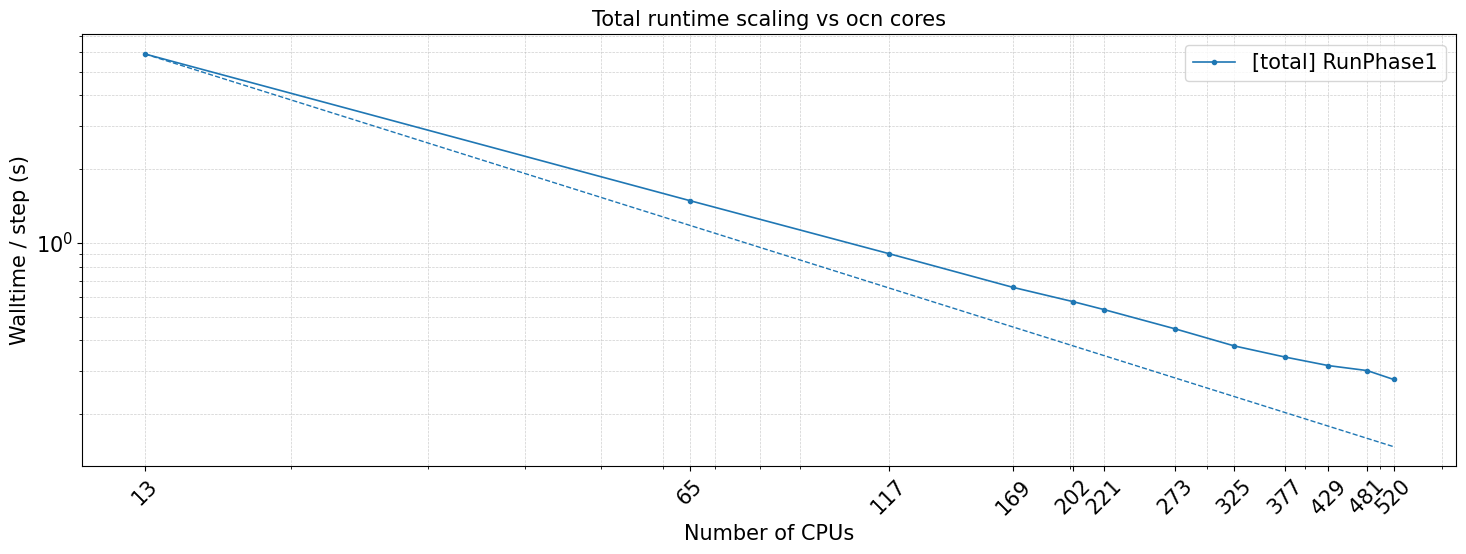

,[total] RunPhase1
__output_name,combine
cores,
13,5.895680
65,1.487199
117,0.904108
169,0.658026
202,0.575067
221,0.534308
273,0.445382
325,0.379535


In [8]:
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
})

cores_tot = [26   , 91     , 156, 208,     221     , 286     , 351     , 416     , 481     , 546     , 611     , 663]
cores_tot = [13, 65, 117, 169, 202, 221, 273, 325, 377, 429, 481, 520]
cores_per_component = {
    "[total] RunPhase1": cores_tot,
    "[OCN] RunPhase1":  cores_tot,
    "[MED-TO-OCN] RunPhase1": cores_tot,
}

new_vars = {
    "[total] RunPhase1": [
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
    ],
#     "[OCN] RunPhase1": [
#         "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
#     ],
#     "[MED-TO-OCN] RunPhase1": [
#         "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
#     ],
}

case_order = [
    "postprocessing_dev-MC-100km-ryf_1",
    "postprocessing_dev-MC-100km-ryf_2",
    "postprocessing_dev-MC-100km-ryf_3",
    "postprocessing_dev-MC-100km-ryf_4",
    "postprocessing_dev-MC-100km-ryf_13",
    # "postprocessing_dev-MC-100km-ryf_12",
    "postprocessing_dev-MC-100km-ryf_5",
    "postprocessing_dev-MC-100km-ryf_6",
    "postprocessing_dev-MC-100km-ryf_7",
    "postprocessing_dev-MC-100km-ryf_8",
    "postprocessing_dev-MC-100km-ryf_9",
    "postprocessing_dev-MC-100km-ryf_10",
    "postprocessing_dev-MC-100km-ryf_11"
]

pivot_scaling_all_components = plot_scaling(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tavg",
    ylabel="Walltime / step (s)",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Total runtime scaling vs ocn cores",
    subplot_by_component=False,
    figsize=(15, 6),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
    loglog=True,
    case_order=case_order,
)

pivot_scaling_all_components

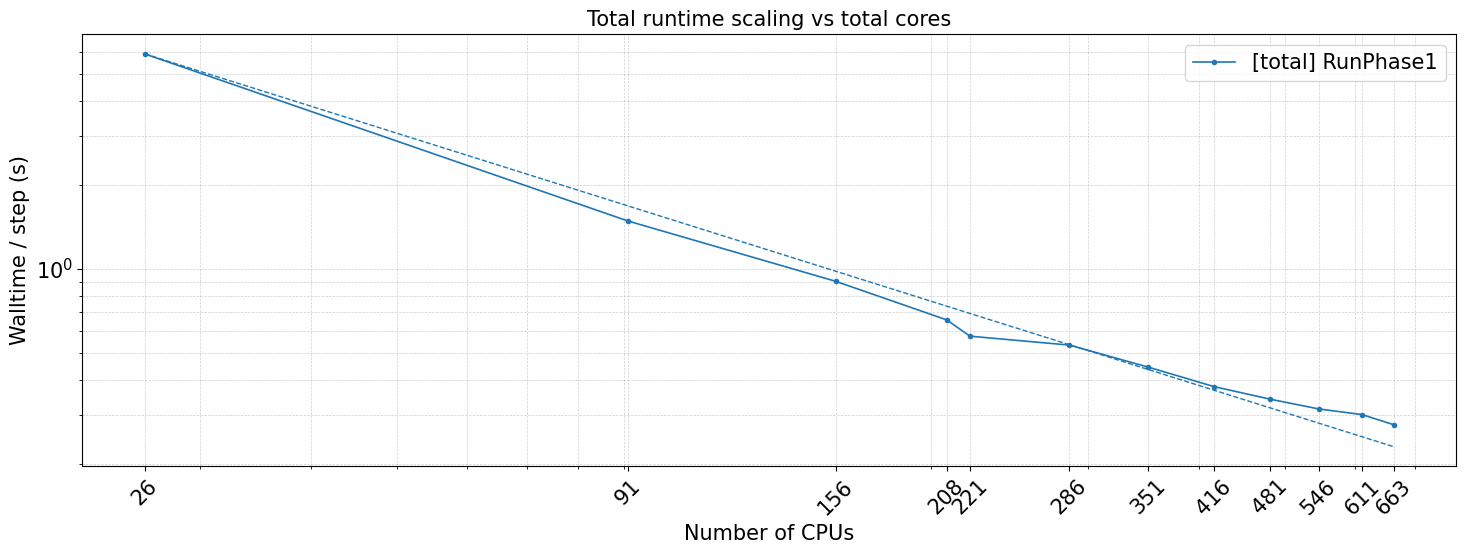

,[total] RunPhase1
__output_name,combine
cores,
26,5.895680
91,1.487199
156,0.904108
208,0.658026
221,0.575067
286,0.534308
351,0.445382
416,0.379535


In [9]:
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
})

cores_tot = [26   , 91     , 156, 208,     221     , 286     , 351     , 416     , 481     , 546     , 611     , 663]
# cores_tot = [13, 65, 117, 169, 202, 221, 273, 325, 377, 429, 481, 520]
cores_per_component = {
    "[total] RunPhase1": cores_tot,
    "[OCN] RunPhase1":  cores_tot,
    "[MED-TO-OCN] RunPhase1": cores_tot,
}

new_vars = {
    "[total] RunPhase1": [
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
    ],
    # "[OCN] RunPhase1": [
    #     "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
    # ],
    # "[MED-TO-OCN] RunPhase1": [
    #     "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
    # ],
}

case_order = [
    "postprocessing_dev-MC-100km-ryf_1",
    "postprocessing_dev-MC-100km-ryf_2",
    "postprocessing_dev-MC-100km-ryf_3",
    "postprocessing_dev-MC-100km-ryf_4",
    "postprocessing_dev-MC-100km-ryf_13",
    # "postprocessing_dev-MC-100km-ryf_12",
    "postprocessing_dev-MC-100km-ryf_5",
    "postprocessing_dev-MC-100km-ryf_6",
    "postprocessing_dev-MC-100km-ryf_7",
    "postprocessing_dev-MC-100km-ryf_8",
    "postprocessing_dev-MC-100km-ryf_9",
    "postprocessing_dev-MC-100km-ryf_10",
    "postprocessing_dev-MC-100km-ryf_11"
]

pivot_scaling_all_components = plot_scaling(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tavg",
    ylabel="Walltime / step (s)",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Total runtime scaling vs total cores",
    subplot_by_component=False,
    figsize=(15, 6),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
    loglog=True,
    case_order=case_order,
)

pivot_scaling_all_components

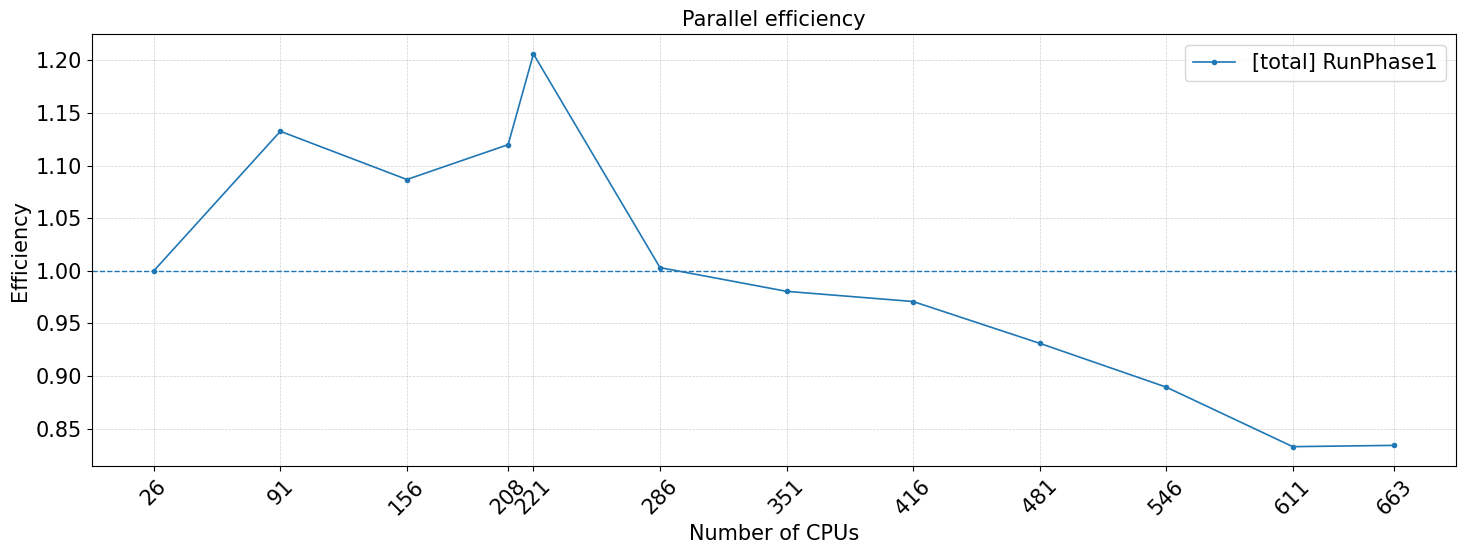

,[total] RunPhase1
,combine
cores,
26,1.000000
91,1.132653
156,1.086832
208,1.119956
221,1.206137
286,1.003112
351,0.980544
416,0.970872


In [10]:
pivot_efficiency_all_components = plot_efficiency(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tavg",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    subplot_by_component=True,
    figsize=(15, 6),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
    case_order=case_order,
)
pivot_efficiency_all_components

## Generate `run-config.yaml` for the MC-100km-ryf config

In [11]:
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write,"
    "[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1"
)

suffix = "test_all_comp"
count=13
base_prefix="dev-MC-100km-ryf"
branch="dev-MC-100km-ryf"
pets=['0 13', '0 26', '0 39', '0 52', '0 65', '0 78', '0 91', '0 104', '0 117', '0 130', '0 143', '0 2', '0 6']
list_pets = [p.replace(' ', ',') for p in pets]

list_exact_path = [f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/{base_prefix}_{i}/{branch}/archive" for i in range(1,count+1)]
post_base_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"

run_config_med_dict = gen_run_config(
    post_base_path=post_base_path,
    model_component=model_component,
    base_prefix=base_prefix,
    count=count,
    list_pets=list_pets,
    list_exact_path=list_exact_path
)

run_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(run_config_med_dict, run_config_med_path)

The above will produce a yaml file `/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_dev-MC-100km-ryf_path_test_all_comp.yaml`

```yaml
default_settings:
  post_base_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/MC-100km-ryf_test_all_comp
  model_component: '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1,[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1,[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write,[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write,[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7,[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1,[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1'
  max_workers: 12
  stream_prefix: esmf_stream
  timeseries_suffix: _timeseries.json
runs:
  - base_prefix: MC-100km-ryf_1
    pets: 0,13
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/MC-100km-ryf_1/MC-100km-ryf/archive
  - base_prefix: MC-100km-ryf_2
    pets: 0,39
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/MC-100km-ryf_2/MC-100km-ryf/archive
  - base_prefix: MC-100km-ryf_3
    pets: 0,78
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/MC-100km-ryf_3/MC-100km-ryf/archive
  - base_prefix: MC-100km-ryf_4
    pets: 0,104
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/MC-100km-ryf_4/MC-100km-ryf/archive
  - base_prefix: MC-100km-ryf_5
    pets: 0,130
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/MC-100km-ryf_5/MC-100km-ryf/archive
  - base_prefix: MC-100km-ryf_6
    pets: 0,156
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/MC-100km-ryf_6/MC-100km-ryf/archive
  - base_prefix: MC-100km-ryf_7
    pets: 0,195
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/MC-100km-ryf_7/MC-100km-ryf/archive
  - base_prefix: MC-100km-ryf_8
    pets: 0,221
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/MC-100km-ryf_8/MC-100km-ryf/archive
  - base_prefix: MC-100km-ryf_9
    pets: 0,247
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/MC-100km-ryf_9/MC-100km-ryf/archive
  - base_prefix: MC-100km-ryf_10
    pets: 0,286
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/MC-100km-ryf_10/MC-100km-ryf/archive
  - base_prefix: MC-100km-ryf_11
    pets: 0,312
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/MC-100km-ryf_11/MC-100km-ryf/archive

```

## Total runtime scaling, speedup and efficiency

Since the `OCN` component runs concurrently with other components, the total runphase scaling is evaluated by taking the mean walltime per timestep for the combined `OCN` component and `MED-to-OCN` coupling (including communication and synchronisation). The runtime scaling, speedup, and efficiency are then computed based on these values.

## Generate `postprocessing-config.yaml` for the MC-100km-ryf config

In [12]:
post_base_path=f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"
save_json_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}/med_json_{suffix}.json"
model_component = [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write",
    "[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
]
model_component = model_component

post_config_med_dict = gen_postprocessing_config(
    post_base_path=post_base_path,
    base_prefix=base_prefix,
    count=count,
    model_component=model_component,
    list_pets=list_pets,
    save_json_path=save_json_path,
    stats_start_index=2,
    stats_end_index=-1,
)
post_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/post_config_{base_prefix}_path_{suffix}_mean.yaml"
write_yaml(post_config_med_dict, post_config_med_path)

## postprocessing-config.yaml
The above will generate a yaml file `/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/post_config_dev-MC-100km-ryf_path_test_all_comp.yaml`

```yaml
default_settings:
  post_base_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/MC-100km-ryf_test_all_comp
  model_component:
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write'
    - '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1'
  save_json_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/MC-100km-ryf_test_all_comp/med_json_test_all_comp.json
  stats_start_index: 0
  stats_end_index:
  stream_prefix: esmf_stream
  timeseries_suffix: _timeseries.json
runs:
  - name: postprocessing_MC-100km-ryf_1
    pets: 0,13
  - name: postprocessing_MC-100km-ryf_2
    pets: 0,39
  - name: postprocessing_MC-100km-ryf_3
    pets: 0,78
  - name: postprocessing_MC-100km-ryf_4
    pets: 0,104
  - name: postprocessing_MC-100km-ryf_5
    pets: 0,130
  - name: postprocessing_MC-100km-ryf_6
    pets: 0,156
  - name: postprocessing_MC-100km-ryf_7
    pets: 0,195
  - name: postprocessing_MC-100km-ryf_8
    pets: 0,221
  - name: postprocessing_MC-100km-ryf_9
    pets: 0,247
  - name: postprocessing_MC-100km-ryf_10
    pets: 0,286
  - name: postprocessing_MC-100km-ryf_11
    pets: 0,312

```


## .parquet file
After running `esmf-trace post-summary-from-yaml --config postprocessing-config.yaml`, a parquet file is then created and can be read through `pd.read_parquet` shown as below.

In [13]:
df = pd.read_parquet(f"{post_base_path}/med_json_{suffix}_table.parquet")
df

,hits,tmin,tmax,tavg,tmedian,tstd,pemin,pemax
name,,,,,,,,
postprocessing_dev-MC-100km-ryf_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1,237.0,0.001860,0.028121,0.009351,0.008941,0.006232,0,0
postprocessing_dev-MC-100km-ryf_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1,237.0,0.130535,0.347447,0.140919,0.133755,0.032403,0,0
postprocessing_dev-MC-100km-ryf_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run,237.0,0.000908,0.001440,0.001014,0.000981,0.000110,0,0
postprocessing_dev-MC-100km-ryf_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum,237.0,0.000067,0.000137,0.000073,0.000072,0.000006,0,0
postprocessing_dev-MC-100km-ryf_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm,237.0,0.000300,0.000621,0.000323,0.000315,0.000029,0,0
...,...,...,...,...,...,...,...,...
postprocessing_dev-MC-100km-ryf_13/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg,237.0,0.004989,0.012600,0.005693,0.005610,0.000614,0,0
postprocessing_dev-MC-100km-ryf_13/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile,237.0,0.000064,0.000503,0.000077,0.000065,0.000053,0,0
postprocessing_dev-MC-100km-ryf_13/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write,237.0,0.000077,0.000256,0.000080,0.000079,0.000012,0,0


## This is for all component scaling overview

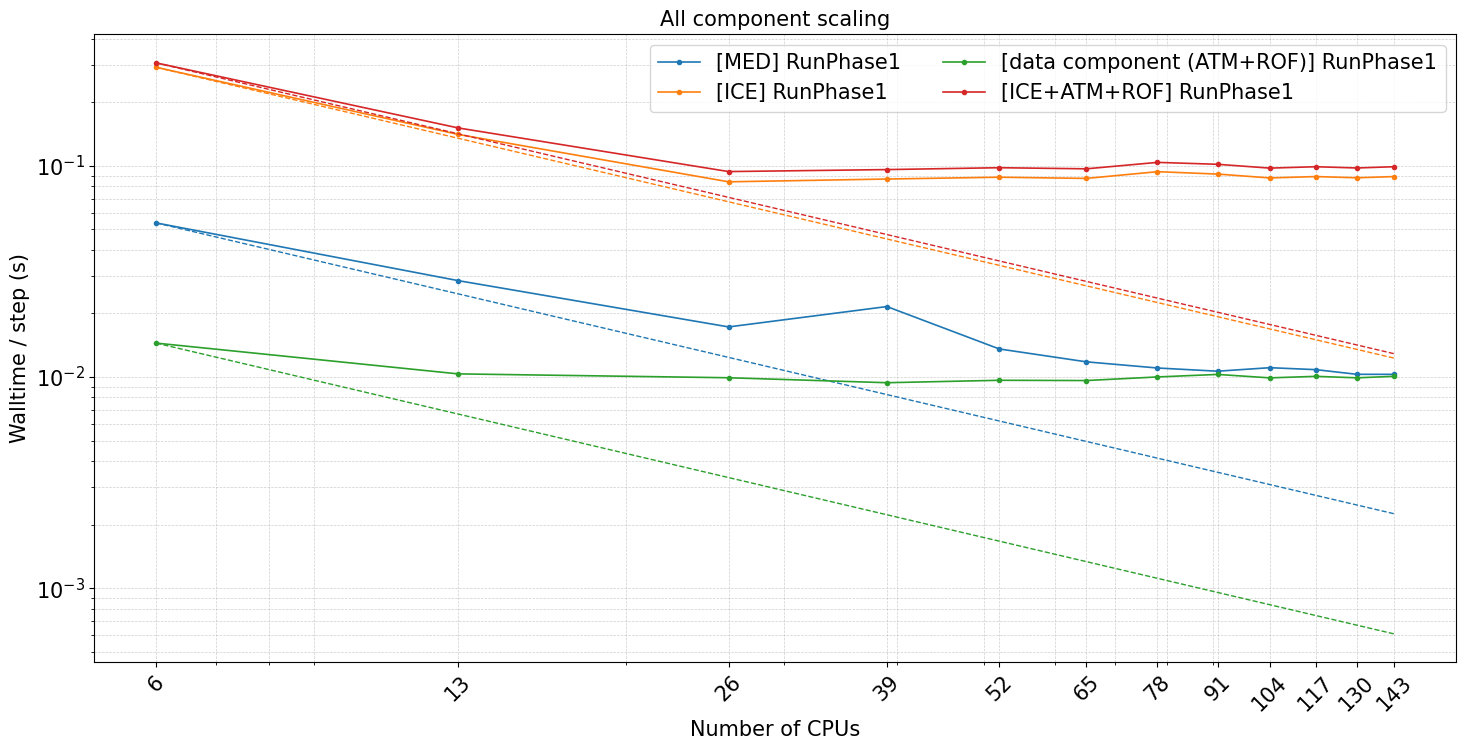

,[MED] RunPhase1,[ICE] RunPhase1,[data component (ATM+ROF)] RunPhase1,[ICE+ATM+ROF] RunPhase1
__output_name,combine,combine,combine,combine
cores,,,,
6,0.053676,0.292872,0.014477,0.307349
13,0.028617,0.140919,0.010350,0.151269
26,0.017271,0.084035,0.009922,0.093957
39,0.021564,0.086620,0.009399,0.096019
52,0.013584,0.088351,0.009652,0.098002
65,0.011803,0.087206,0.009624,0.096830
78,0.011034,0.093851,0.010010,0.103861
91,0.010656,0.091427,0.010287,0.101714


In [14]:

plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
})

cores=[6, 13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143]

cores_per_component = {
    "[MED] RunPhase1": cores,
    "[ICE] RunPhase1": cores,
    "[data component (ATM+ROF)] RunPhase1": cores,
    "[ICE+ATM+ROF] RunPhase1": cores,
    # "[OCN] RunPhase1": cores_ocn,
}

new_vars = {
    "[MED] RunPhase1": [
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write",
    ],
    "[ICE] RunPhase1": [
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1",
    ],
    "[data component (ATM+ROF)] RunPhase1":[
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1",
    ],
    "[ICE+ATM+ROF] RunPhase1":[
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1",
    ],
    # "[OCN] RunPhase1": [
    #     "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1"
    # ],
    
}

case_order = [
    # "postprocessing_dev-MC-100km-ryf_12",
    "postprocessing_dev-MC-100km-ryf_13",
    "postprocessing_dev-MC-100km-ryf_1",
    "postprocessing_dev-MC-100km-ryf_2",
    "postprocessing_dev-MC-100km-ryf_3",
    "postprocessing_dev-MC-100km-ryf_4",
    "postprocessing_dev-MC-100km-ryf_5",
    "postprocessing_dev-MC-100km-ryf_6",
    "postprocessing_dev-MC-100km-ryf_7",
    "postprocessing_dev-MC-100km-ryf_8",
    "postprocessing_dev-MC-100km-ryf_9",
    "postprocessing_dev-MC-100km-ryf_10",
    "postprocessing_dev-MC-100km-ryf_11"
]

pivot_scaling_all_components = plot_scaling(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tavg",
    ylabel="Walltime / step (s)",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="All component scaling",
    subplot_by_component=False,
    figsize=(15, 8),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
    case_order=case_order,
)

pivot_scaling_all_components

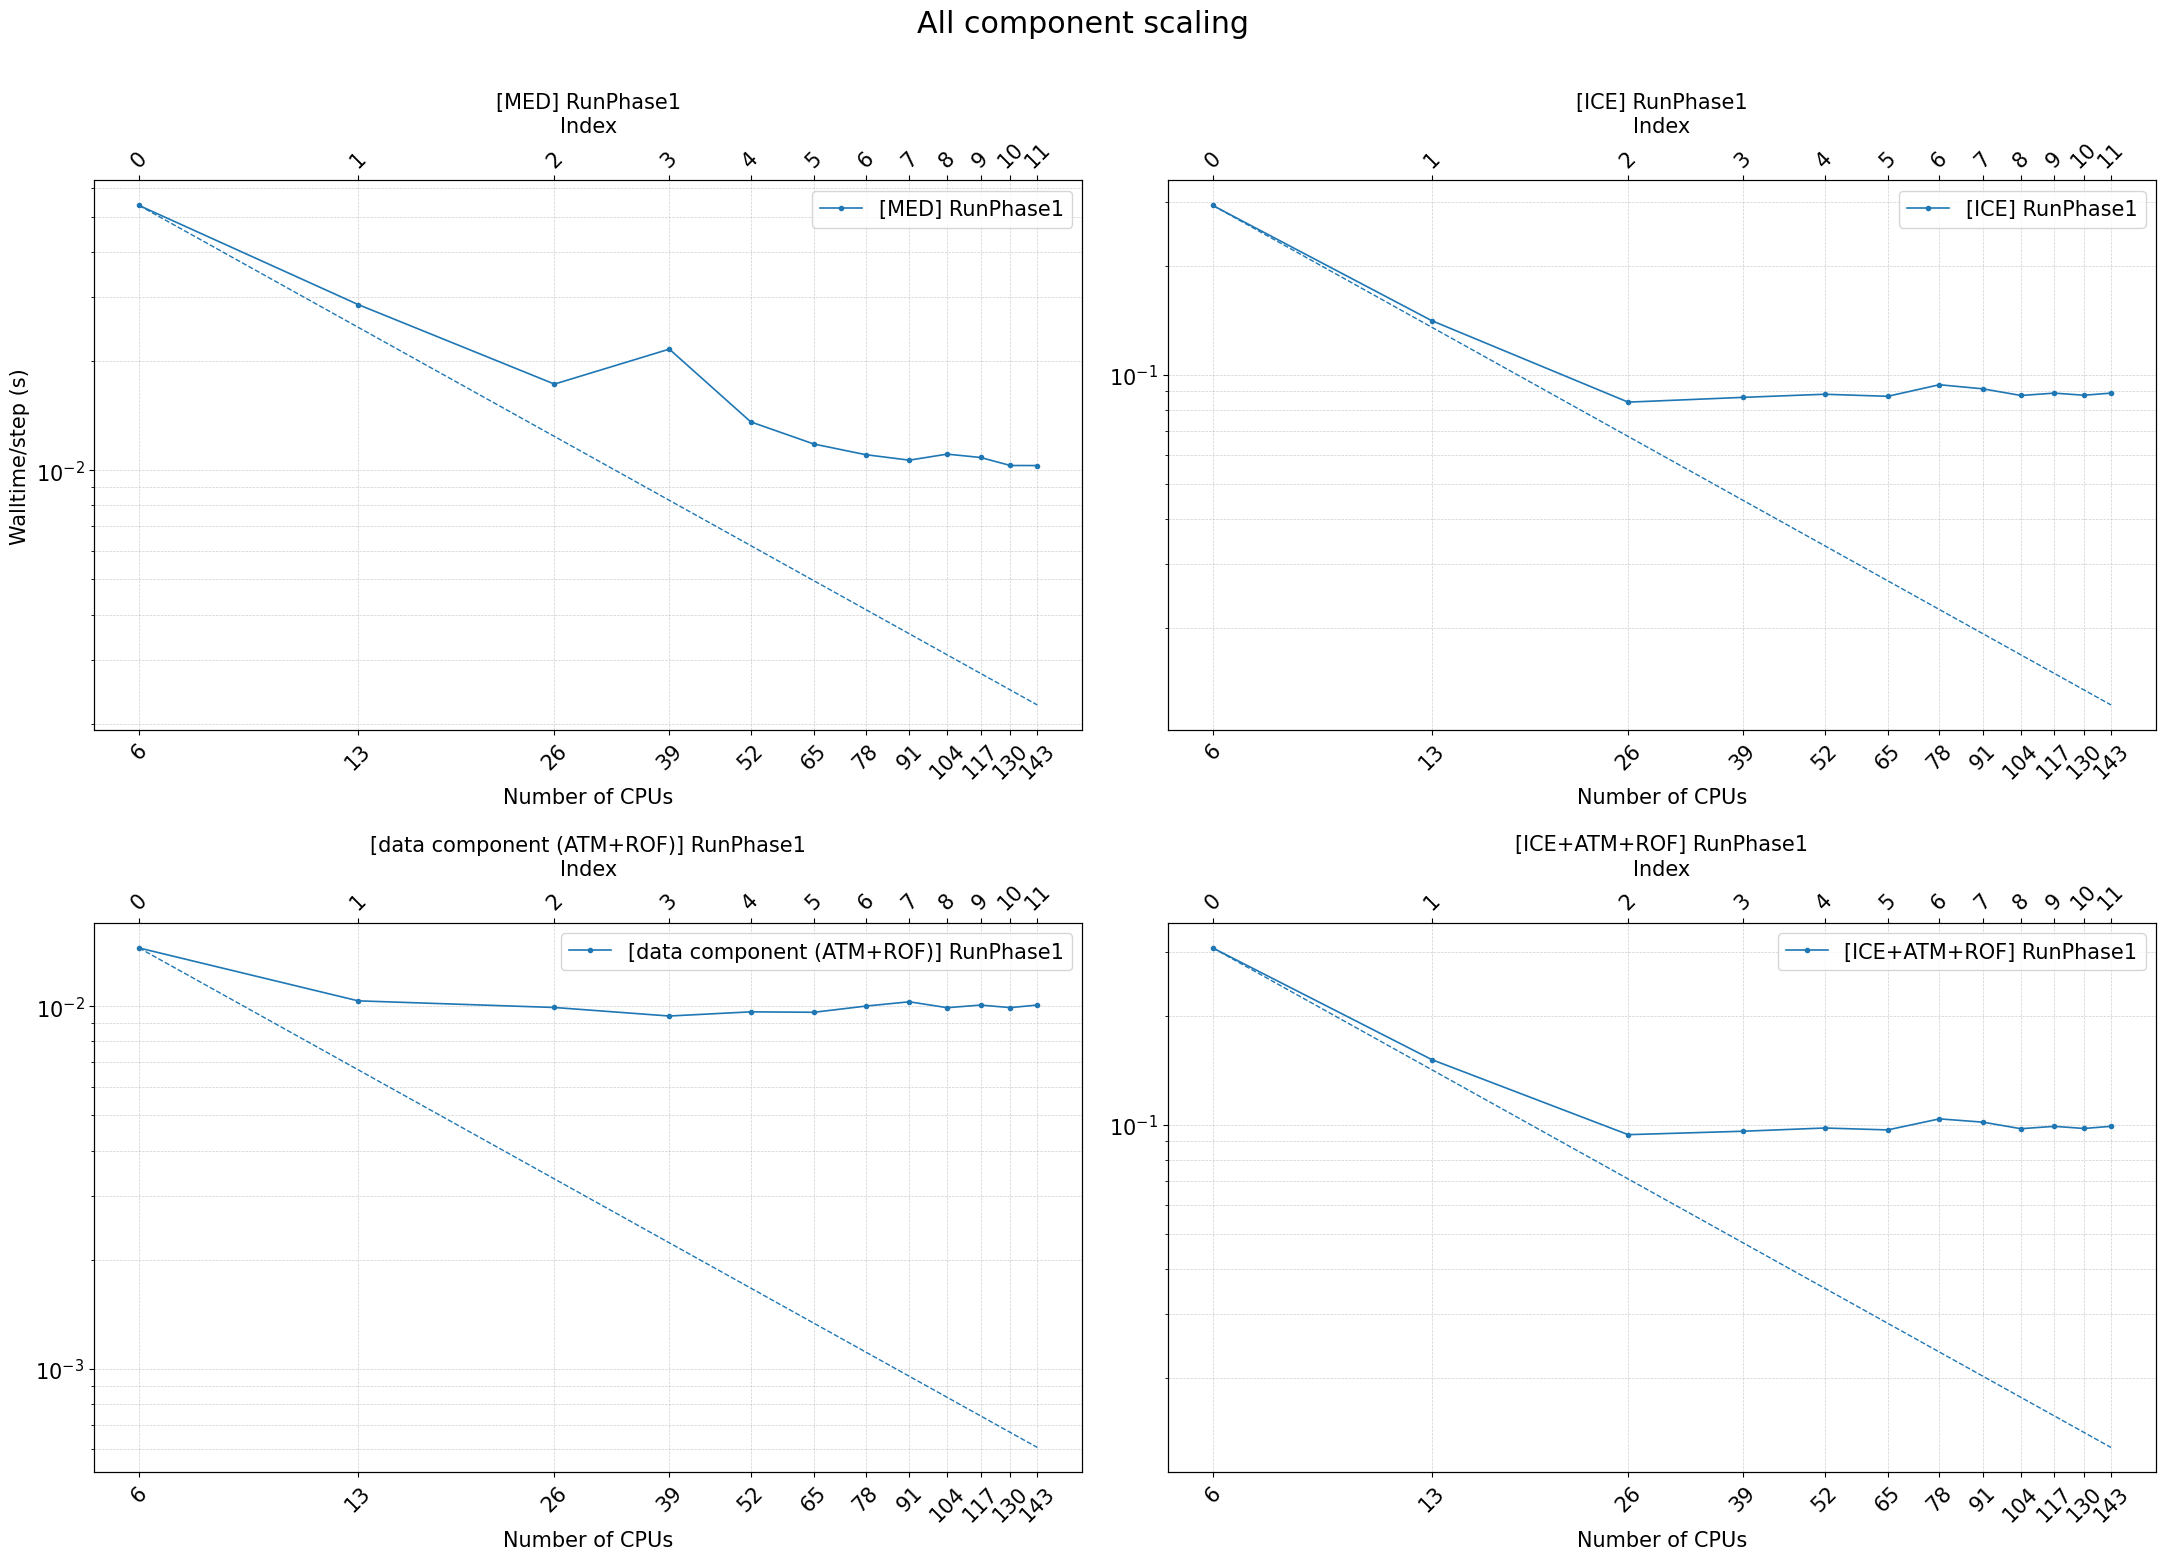

,[MED] RunPhase1,[ICE] RunPhase1,[data component (ATM+ROF)] RunPhase1,[ICE+ATM+ROF] RunPhase1
__output_name,combine,combine,combine,combine
cores,,,,
6,0.053676,0.292872,0.014477,0.307349
13,0.028617,0.140919,0.010350,0.151269
26,0.017271,0.084035,0.009922,0.093957
39,0.021564,0.086620,0.009399,0.096019
52,0.013584,0.088351,0.009652,0.098002
65,0.011803,0.087206,0.009624,0.096830
78,0.011034,0.093851,0.010010,0.103861
91,0.010656,0.091427,0.010287,0.101714


In [15]:
pivot_scaling_all_components = plot_scaling(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tavg",
    ylabel="Walltime/step (s)",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="All component scaling",
    subplot_by_component=True,
    figsize=(22, 16),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
    case_order=case_order,
)
pivot_scaling_all_components

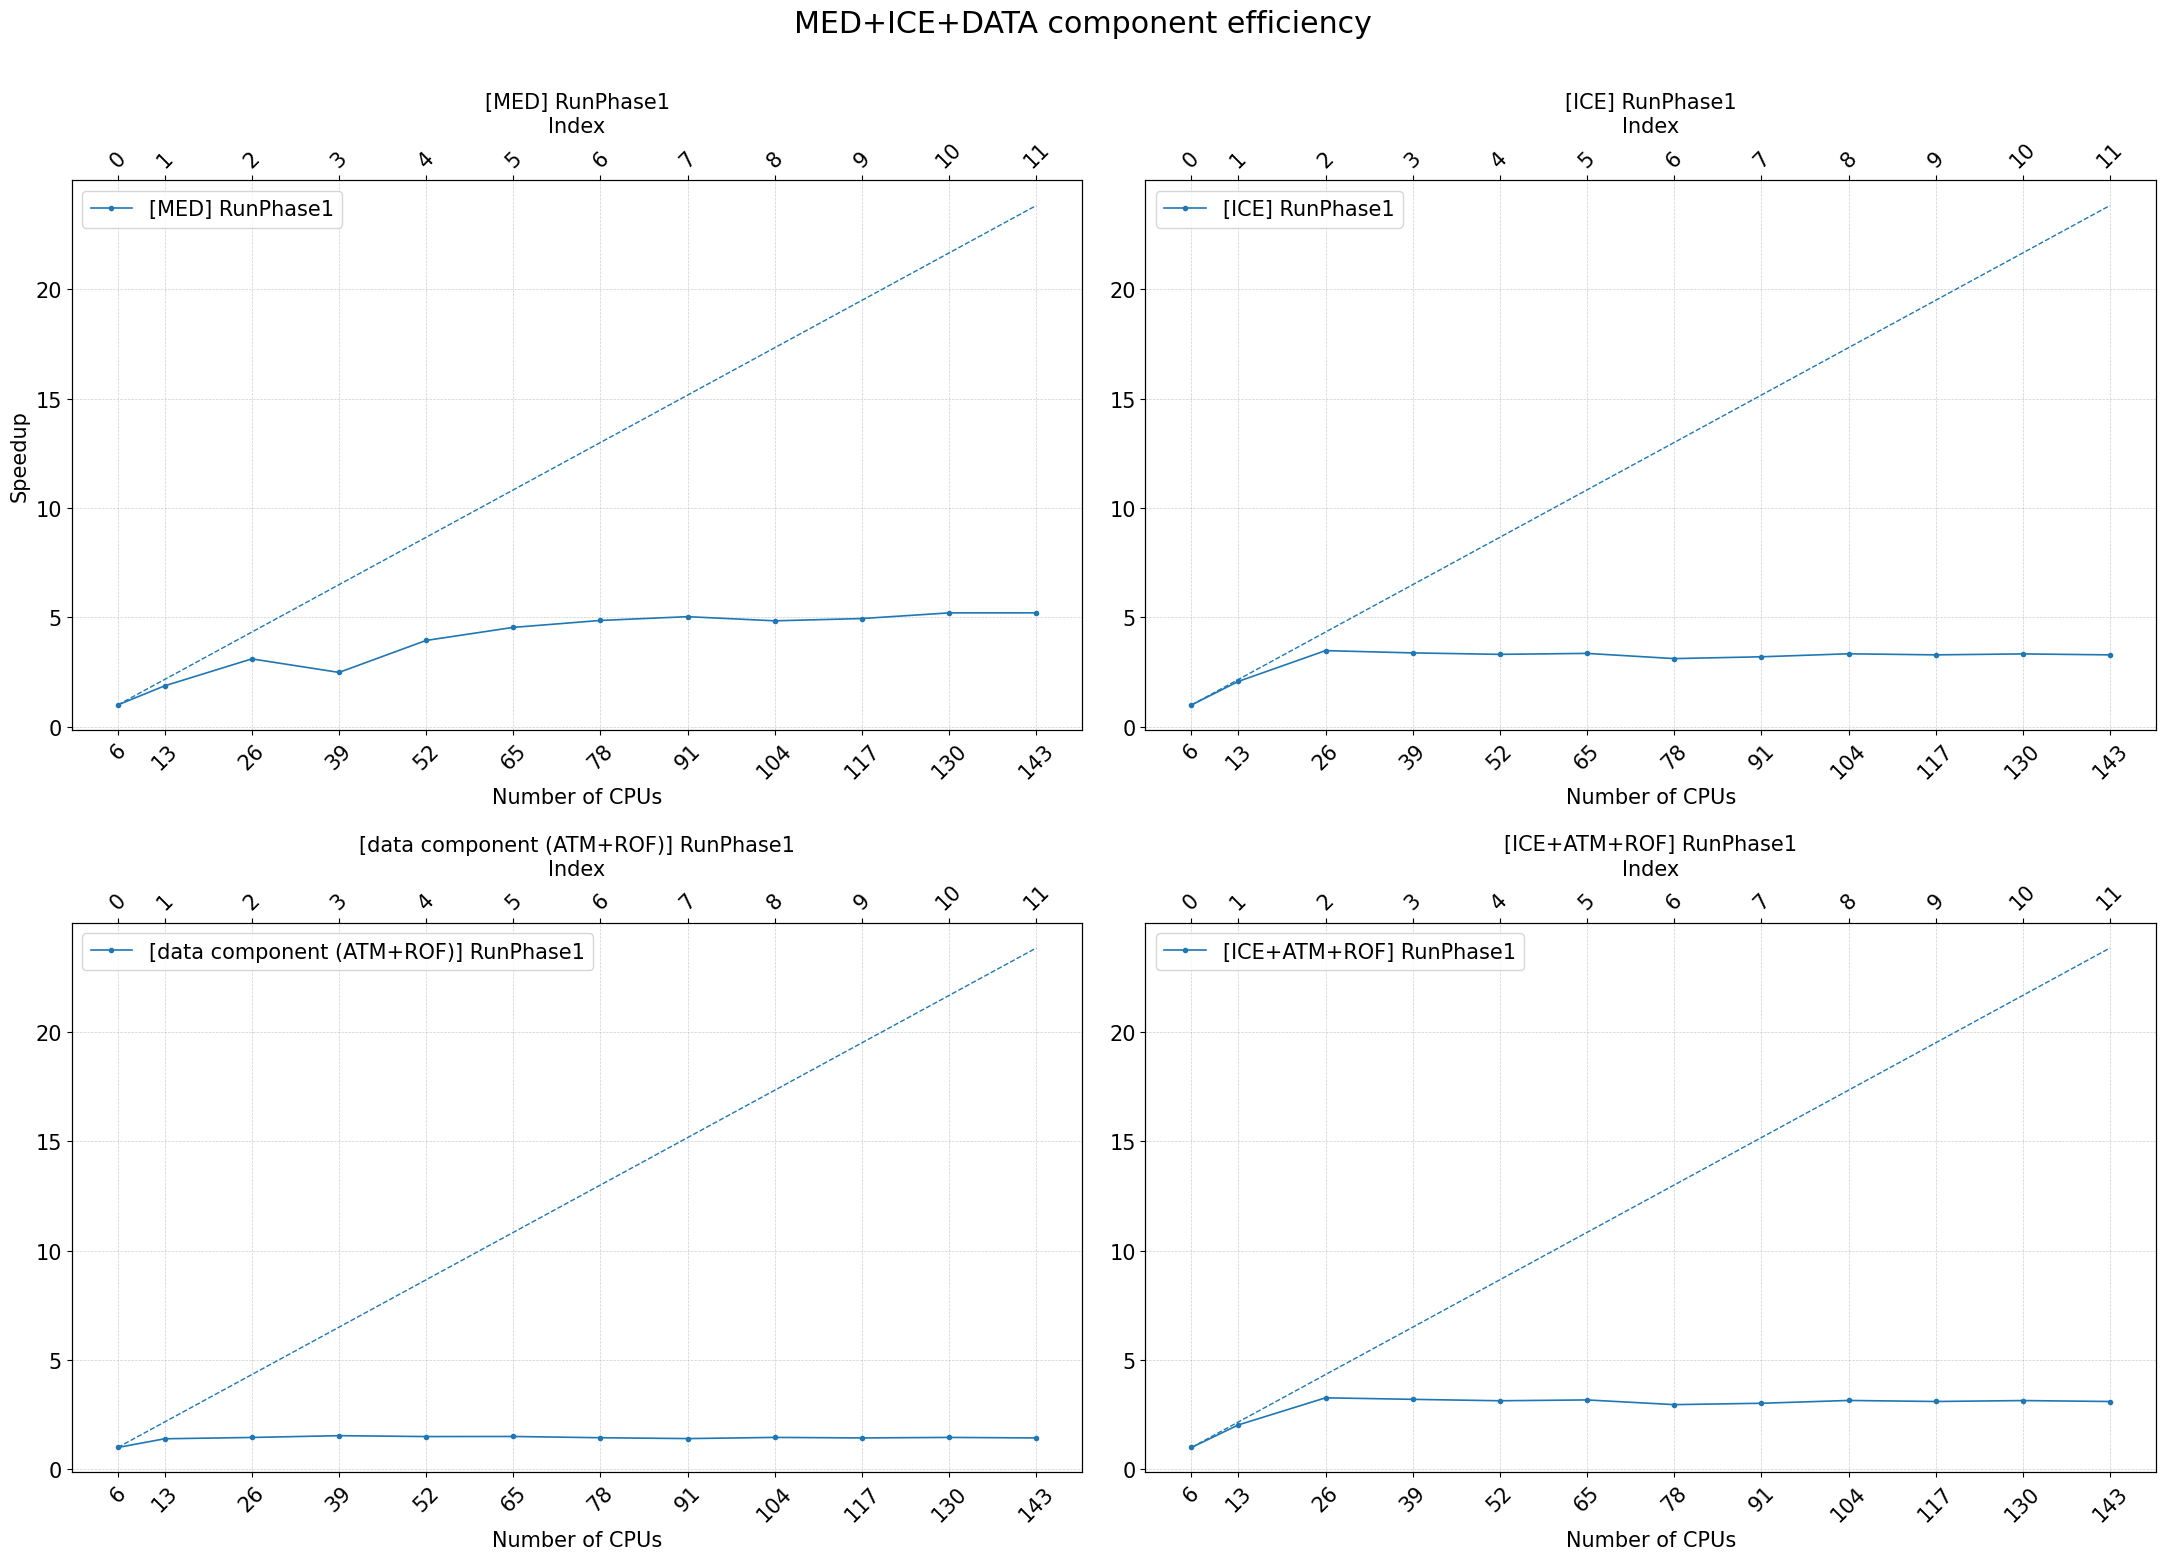

,[MED] RunPhase1,[ICE] RunPhase1,[data component (ATM+ROF)] RunPhase1,[ICE+ATM+ROF] RunPhase1
,combine,combine,combine,combine
cores,,,,
6,1.000000,1.000000,1.000000,1.000000
13,1.875680,2.078295,1.398774,2.031802
26,3.107810,3.485103,1.459153,3.271166
39,2.489177,3.381113,1.540317,3.200925
52,3.951266,3.314875,1.499992,3.136140
65,4.547801,3.358390,1.504245,3.174100
78,4.864619,3.120597,1.446327,2.959238
91,5.037225,3.203351,1.407279,3.021696


In [16]:
pivot_speedup_all_components = plot_speedup(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tavg",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="MED+ICE+DATA component speedup",
    subplot_by_component=True,
    figsize=(22, 16),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
    case_order=case_order,
)
pivot_speedup_all_components

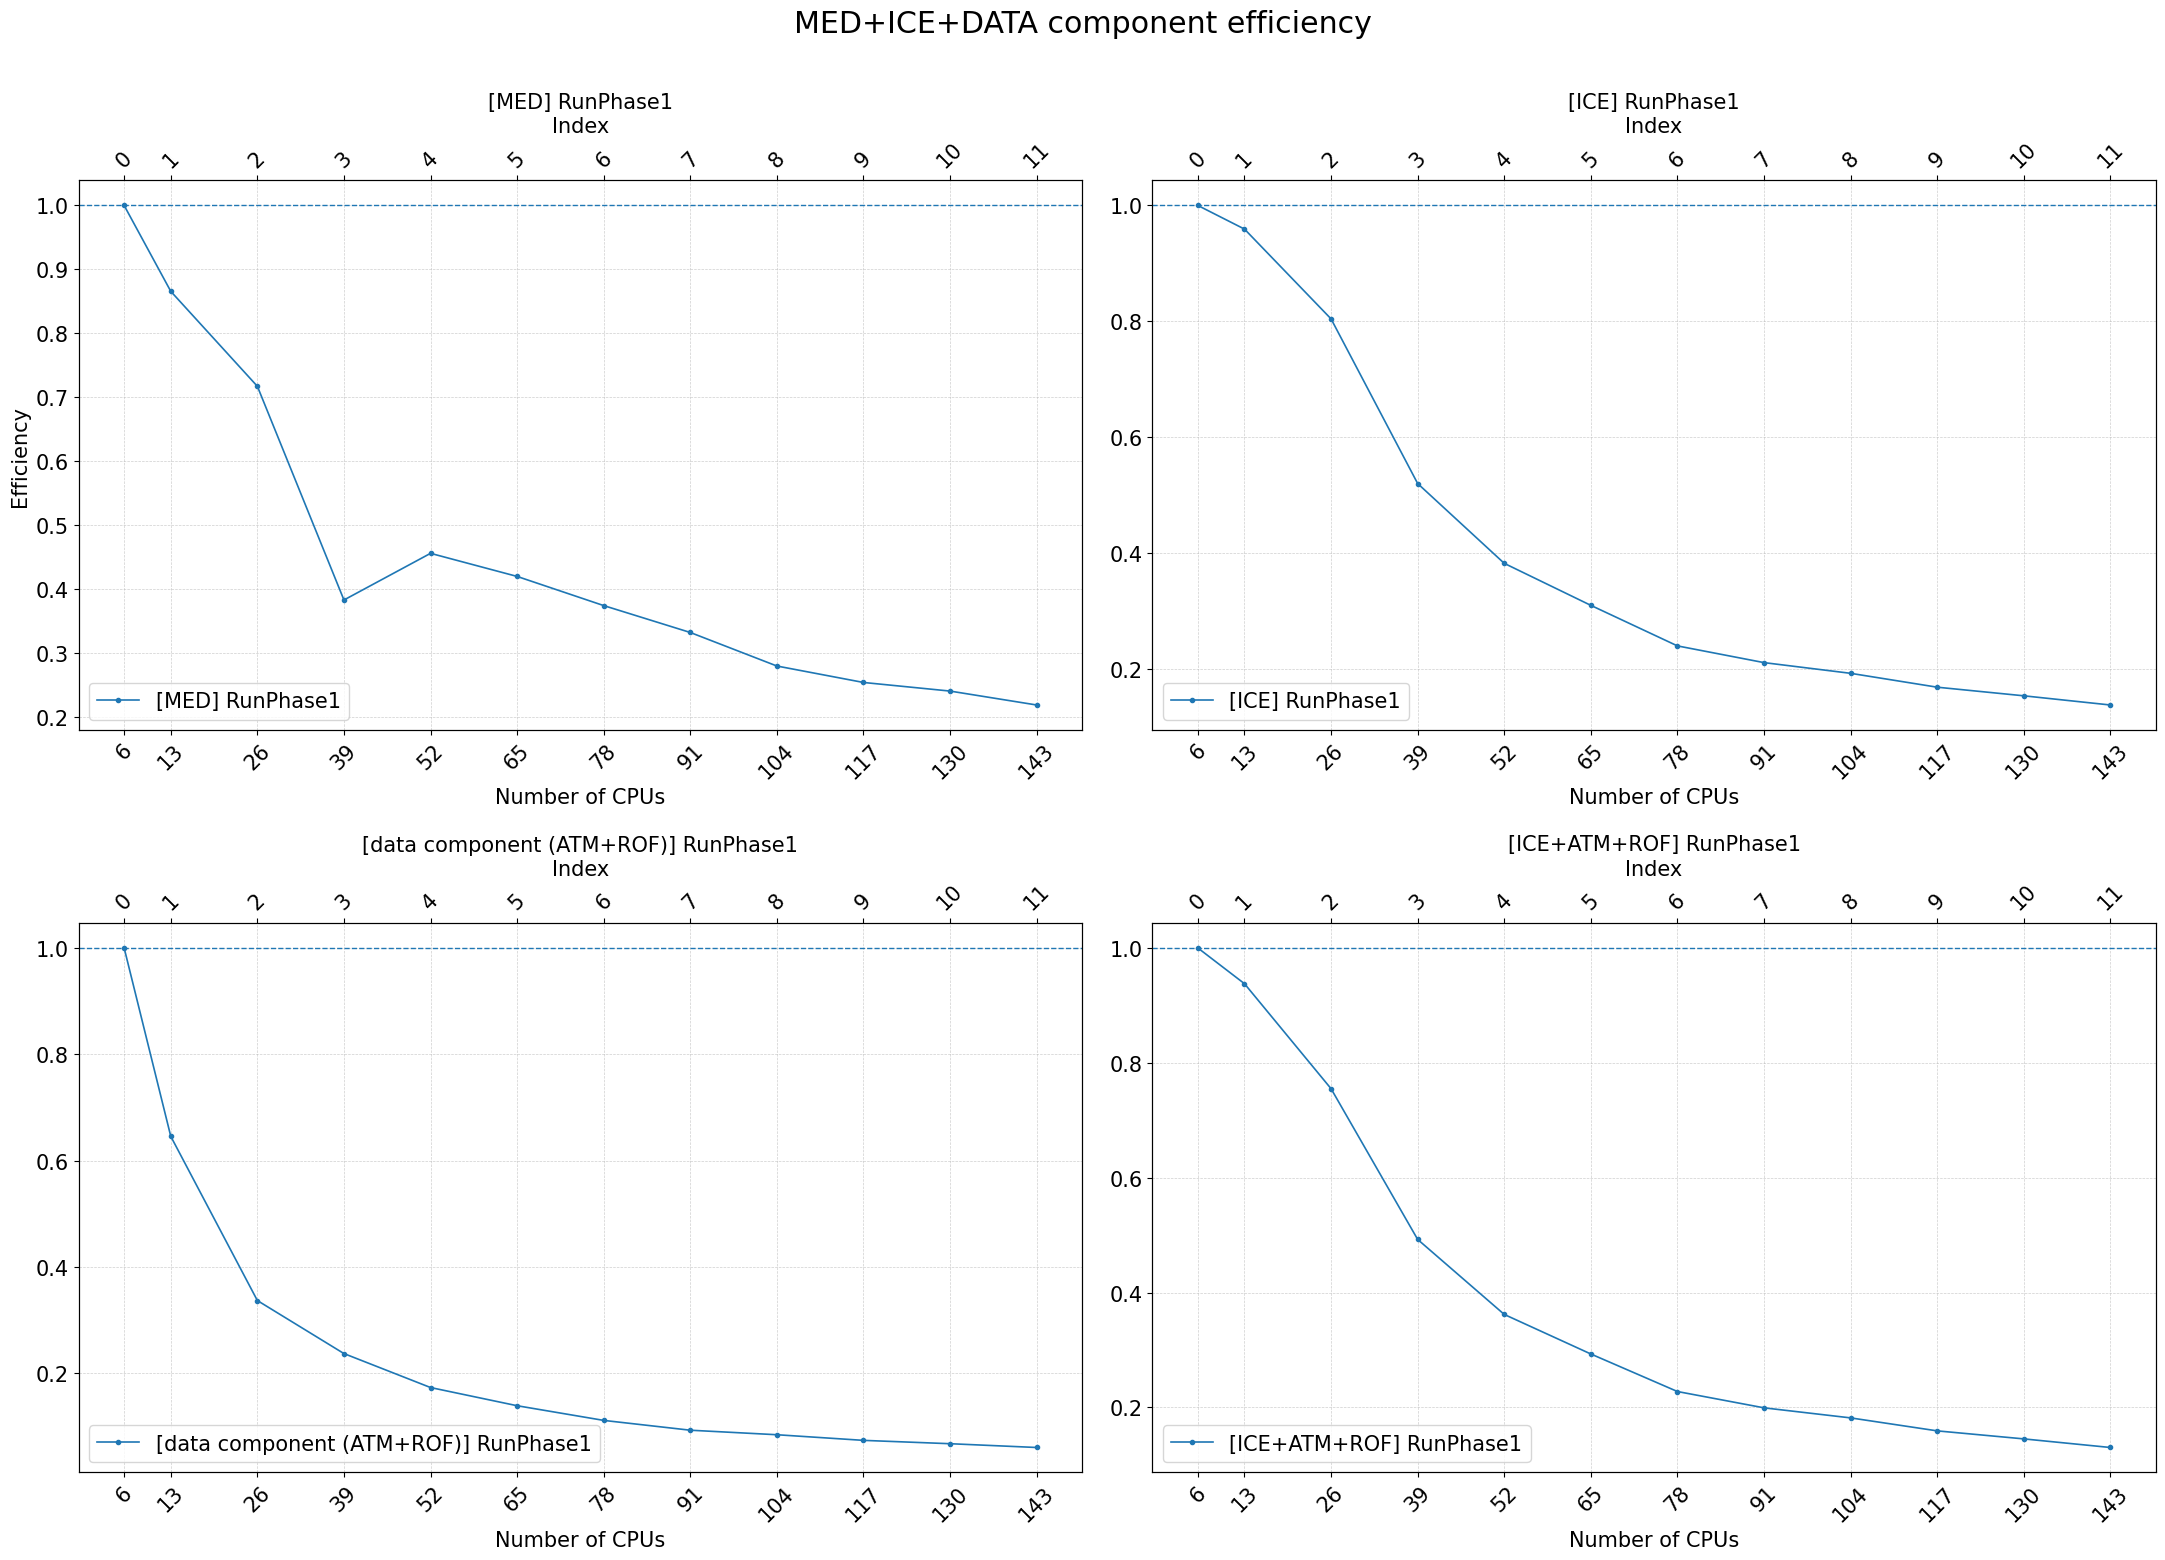

,[MED] RunPhase1,[ICE] RunPhase1,[data component (ATM+ROF)] RunPhase1,[ICE+ATM+ROF] RunPhase1
,combine,combine,combine,combine
cores,,,,
6,1.000000,1.000000,1.000000,1.000000
13,0.865698,0.959213,0.645588,0.937755
26,0.717187,0.804254,0.336728,0.754885
39,0.382950,0.520171,0.236972,0.492450
52,0.455915,0.382486,0.173076,0.361862
65,0.419797,0.310005,0.138853,0.292994
78,0.374201,0.240046,0.111256,0.227634
91,0.332125,0.211210,0.092788,0.199233


In [17]:
pivot_efficiency_all_components = plot_efficiency(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tavg",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="MED+ICE+DATA component efficiency",
    subplot_by_component=True,
    figsize=(22, 16),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
    case_order=case_order,
)
pivot_efficiency_all_components

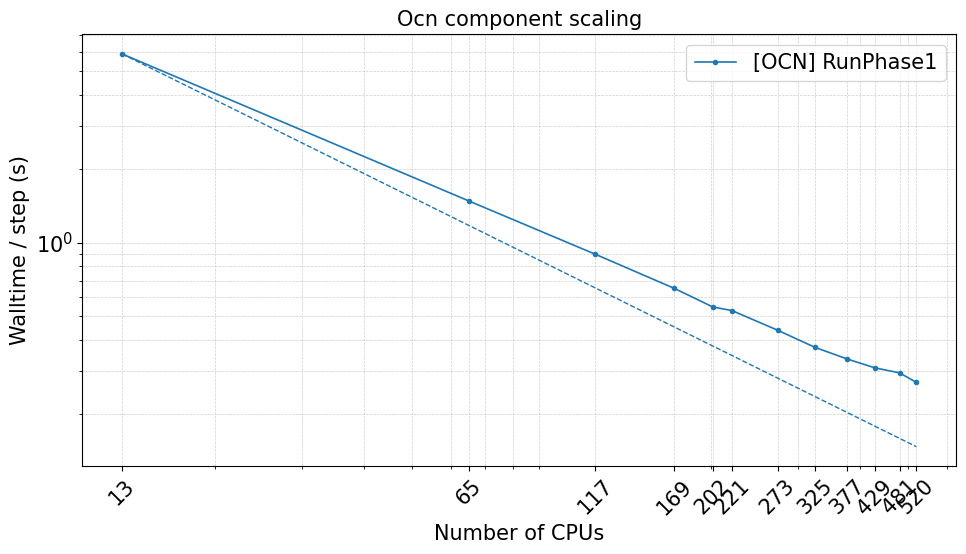

,[OCN] RunPhase1
__output_name,combine
cores,
6,NaN
13,5.880952
26,NaN
39,NaN
52,NaN
65,1.479692
78,NaN
91,NaN


In [18]:
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
})

cores_ocn=[13, 65, 117, 169, 202, 221, 273, 325, 377, 429, 481, 520]

cores_per_component = {
    "[MED] RunPhase1": cores,
    "[ICE] RunPhase1": cores,
    "[data component (ATM+ROF)] RunPhase1": cores,
    "[ICE+ATM+ROF] RunPhase1": cores,
    "[OCN] RunPhase1": cores_ocn,
}

new_vars = {
    "[OCN] RunPhase1": [
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1"
    ],
    
}

case_order = [
    "postprocessing_dev-MC-100km-ryf_1",
    "postprocessing_dev-MC-100km-ryf_2",
    "postprocessing_dev-MC-100km-ryf_3",
    "postprocessing_dev-MC-100km-ryf_4",
    "postprocessing_dev-MC-100km-ryf_13",
    # "postprocessing_dev-MC-100km-ryf_12",
    "postprocessing_dev-MC-100km-ryf_5",
    "postprocessing_dev-MC-100km-ryf_6",
    "postprocessing_dev-MC-100km-ryf_7",
    "postprocessing_dev-MC-100km-ryf_8",
    "postprocessing_dev-MC-100km-ryf_9",
    "postprocessing_dev-MC-100km-ryf_10",
    "postprocessing_dev-MC-100km-ryf_11"
]

pivot_scaling_all_components = plot_scaling(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tavg",
    ylabel="Walltime / step (s)",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Ocn component scaling",
    subplot_by_component=False,
    figsize=(10, 6),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
    case_order=case_order,
)

pivot_scaling_all_components




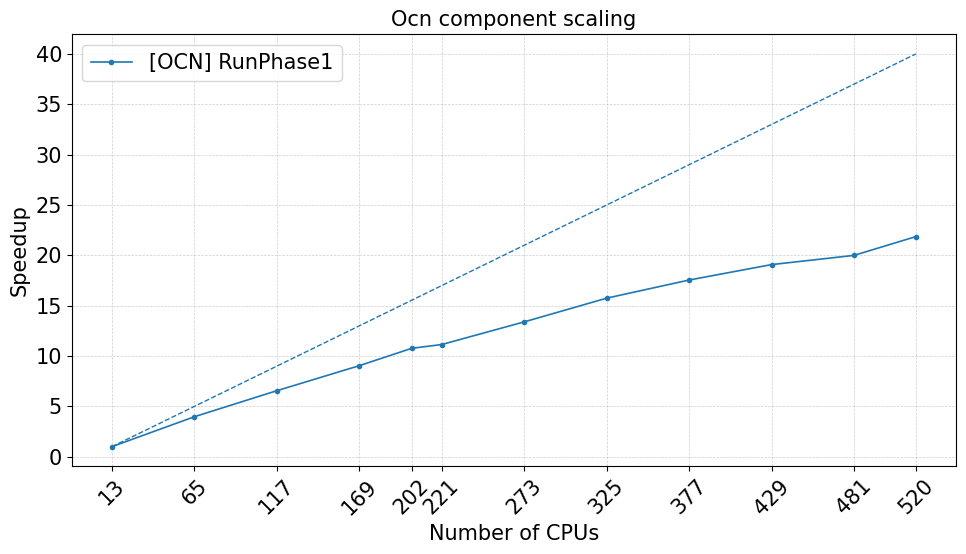

,[OCN] RunPhase1
,combine
cores,
6,NaN
13,1.000000
26,NaN
39,NaN
52,NaN
65,3.974444
78,NaN
91,NaN


In [19]:
pivot_speedup_all_components = plot_speedup(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tavg",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Ocn component scaling",
    subplot_by_component=False,
    figsize=(10, 6),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
    case_order=case_order,
)

pivot_speedup_all_components

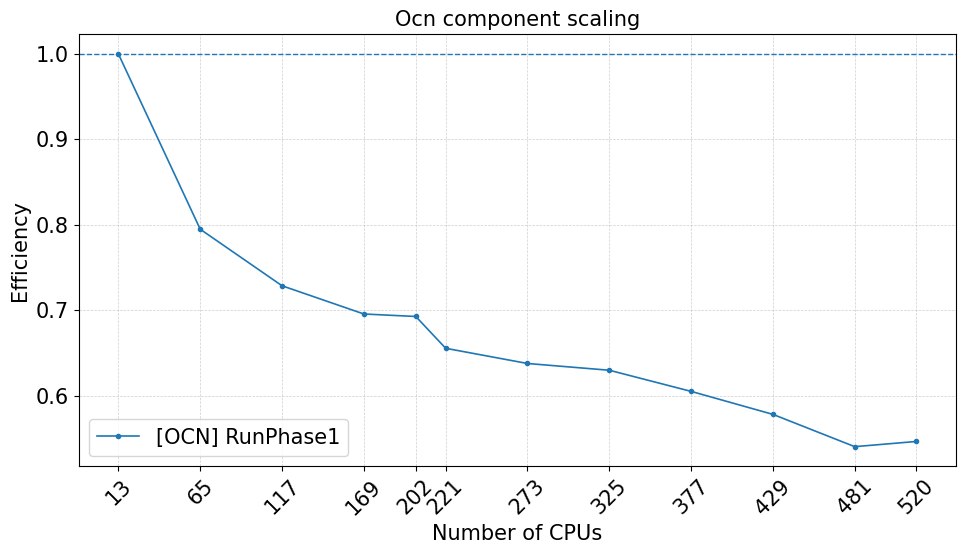

,[OCN] RunPhase1
,combine
cores,
6,NaN
13,1.000000
26,NaN
39,NaN
52,NaN
65,0.794889
78,NaN
91,NaN


In [20]:
pivot_efficiency_all_components = plot_efficiency(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tavg",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Ocn component scaling",
    subplot_by_component=False,
    figsize=(10, 6),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
    case_order=case_order,
)

pivot_efficiency_all_components